In [11]:
import pandas as pd

import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools as pdt
from rdkit.Chem import GraphDescriptors

import seaborn as sns

In [12]:
def gaussianScaler(numArr):
    mean = numArr.mean()
    std = numArr.std()
    numArr = (numArr - mean) / std
    return numArr

def logScaler(numArr):
    numArr = np.log(numArr)
    return numArr

def createQuantiles(dfColumn, numQuantiles):
  return pd.qcut(dfColumn, numQuantiles, labels=False, duplicates='drop')

def minMaxScaler(numArr):
  minx = np.min(numArr)
  maxx = np.max(numArr)
  numArr = (numArr - minx) / (maxx - minx)
  return numArr

In [13]:
# load dataset
cp_data = pdt.LoadSDF('../chembl_data_sdf/CHEMBL244_actives.sdf', embedProps=True, molColName=None, smilesName='smiles')
# drop unnecessary information
print(cp_data.nunique())

CdId             4226
Mol Weight       3057
Formula          3074
cmpd_chemblid    4226
std_type            1
std_value        1038
std_unit            1
target_id           1
target_name         1
organism            1
target_type         1
ID                  1
smiles           4225
dtype: int64


In [14]:
cp_data = cp_data.drop(['CdId','Mol Weight','Formula','target_id','target_name','organism','target_type','ID','std_unit','std_type'],axis=1)

In [15]:
cp_data.tail()

,cmpd_chemblid,std_value,smiles
4221,CHEMBL427842,2.6,O=C(N[C@H]1CCC[C@H]1NC(=O)c1ccc2c(Cl)c[nH]c2c1...
4222,CHEMBL1761614,305.0,CN1CCc2nc(C(=O)NC[C@@H](CC(=O)O)NC(=O)c3cc4cc(...
4223,CHEMBL272042,32.0,CCOC(=O)CN(CCCS(=O)(=O)c1ccc2cc(Cl)ccc2c1)C(=O...
4224,CHEMBL539053,40.0,CC(=N)N1CC[C@H](Oc2ccc([C@H](Cc3ccc4ccc(C(=N)N...
4225,CHEMBL371336,4.25,Nc1cc(C(=O)NC[C@H]2CN(c3ccc(N4CCOCC4=O)cc3)C(=...


<AxesSubplot:xlabel='std_value', ylabel='Density'>

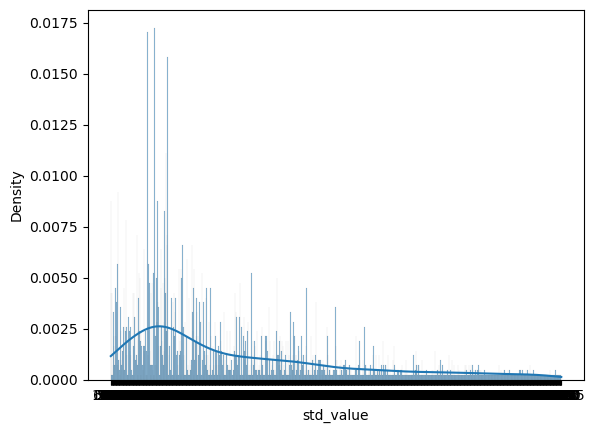

In [7]:
sns.histplot(cp_data['std_value'],kde=True,stat='density')

In [37]:
class Featurizer:
    def __init__(self, smiles_col='smiles', activity_col='std_value', **kwargs):
        self.smiles_col = smiles_col
        self.activity_col = activity_col
        self.__dict__.update(kwargs)
    
    def __call__(self, df):
        raise NotImplementedError()

class MyFeaturizer(Featurizer):
    def __init__(self, activity_dist='gaussian', qcount=0, radius=2, length=1024, **kwargs):
        self.activity_dist = activity_dist
        self.qcount = qcount
        self.radius = radius
        self.length = length
        super().__init__(**kwargs)
    
    def __call__(self, df,quick=False):
        if(self.activity_dist != 'gaussian' and self.activity_dist != 'powerlaw' and self.activity_dist != 'quantiles'):
            print('wrongly set attribute activity_dist. Please use one of the following:\ngaussian, powerlaw, quantiles')
            return pd.DataFrame()
        if(self.activity_dist == 'quantiles' and self.qcount < 1):
            print('wrongly set quantile count.')
            return pd.DataFrame()
        df[self.activity_col] = df[self.activity_col].astype(float)
        c = ['activity']+['f_'+str(n) for n in np.arange(self.length)]
        if quick:
            features = []
        else:
            features = pd.DataFrame(columns=c)
        match self.activity_dist:
            case 'gaussian':
                df[self.activity_col] = gaussianSacler(df[self.activity_col])
            case 'powerlaw':
                df[self.activity_col] = logScaler(df[self.activity_col])
            case 'quantiles':
                df[self.activity_col] = createQuantiles(df[self.activity_col], self.qcount)
                df[self.activity_col] = minMaxScaler(df[self.activity_col])
            case _:
                #do nothing
                return
        for i, row in df.iterrows():
            smiles = row[self.smiles_col]
            activity = row[self.activity_col]
            mol = Chem.MolFromSmiles(smiles)
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, self.radius, nBits=self.length)
            fpvector = np.array(fp,dtype=int)
            vec = np.array([np.hstack(([activity],fpvector))],dtype=float)
            if quick:
                features.append(vec)
            else:
                fta = pd.DataFrame(vec,columns=c)
                features = pd.concat([features,fta],ignore_index=True)
            if i % 100 == 0:
                print(i,'/',4225)
        #res = pd.DataFrame(features,columns=c)
        #return res
        return features

In [46]:
feature_count = 512+1 # + activity
featurizer = MyFeaturizer(activity_dist='quantiles',qcount=70,length=feature_count)
feature_count = feature_count * 1.0
data = featurizer(cp_data)

0 / 4225
100 / 4225
200 / 4225
300 / 4225
400 / 4225
500 / 4225
600 / 4225
700 / 4225
800 / 4225
900 / 4225
1000 / 4225
1100 / 4225
1200 / 4225
1300 / 4225
1400 / 4225
1500 / 4225
1600 / 4225
1700 / 4225
1800 / 4225
1900 / 4225
2000 / 4225
2100 / 4225
2200 / 4225
2300 / 4225
2400 / 4225
2500 / 4225
2600 / 4225
2700 / 4225
2800 / 4225
2900 / 4225
3000 / 4225
3100 / 4225
3200 / 4225
3300 / 4225
3400 / 4225
3500 / 4225
3600 / 4225
3700 / 4225
3800 / 4225
3900 / 4225
4000 / 4225
4100 / 4225
4200 / 4225


In [22]:
data.tail()

,smiles,activity,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_1014,f_1015,f_1016,f_1017,f_1018,f_1019,f_1020,f_1021,f_1022,f_1023
4221,O=C(N[C@H]1CCC[C@H]1NC(=O)c1ccc2c(Cl)c[nH]c2c1...,0.2898550724637681,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4222,CN1CCc2nc(C(=O)NC[C@@H](CC(=O)O)NC(=O)c3cc4cc(...,0.8695652173913043,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4223,CCOC(=O)CN(CCCS(=O)(=O)c1ccc2cc(Cl)ccc2c1)C(=O...,0.6086956521739131,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4224,CC(=N)N1CC[C@H](Oc2ccc([C@H](Cc3ccc4ccc(C(=N)N...,0.6231884057971014,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4225,Nc1cc(C(=O)NC[C@H]2CN(c3ccc(N4CCOCC4=O)cc3)C(=...,0.36231884057971014,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


<AxesSubplot:xlabel='activity', ylabel='Density'>

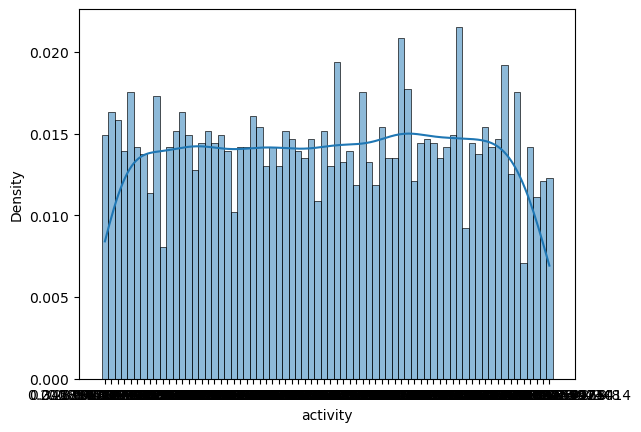

In [23]:
#data = pd.DataFrame(data,columns=['smiles','activity']+['f_'+str(n) for n in np.arange(1024)])
sns.histplot(data['activity'],kde=True,stat='density')

In [47]:
def getSimilarity(obj1,obj2):
    similarity = obj1 - obj2
    similarity = np.sum((similarity**2.0) / feature_count)
    similarity = 1 - math.sqrt(similarity)
    return similarity

def dfSimilarity(df, centroids):
  ### dfSimilarity = Calculate similarities for dataframe input
  ### We need to calculate ||a-b||^2 = |a|^2 + |b|^2 - 2*|a|*|b|
  ### Implement this with matrix operations
  ### See the Appendix for further explanation
  numPoints = len(df.index)
  numCentroids = len(centroids.index)
  ## Strictly speaking, we don't need to calculate the norm of points
  # because it adds a constant bias to distances
  # But calculating it so that the similarity doesn't go negative
  # And that we expect similarities in [0,1] which aids debugging
  pointNorms = np.square(np.linalg.norm(df, axis=1))
  pointNorms = np.reshape(pointNorms, [numPoints, 1])
  ## Calculate the norm of centroids
  centroidNorms = np.square(np.linalg.norm(centroids, axis=1))
  centroidNorms = np.reshape(centroidNorms, (1, numCentroids))
  ## Calculate |a|^2 + |b|^2 - 2*|a|*|b|
  similarities = pointNorms + centroidNorms - 2.0 * np.dot(
      df, np.transpose(centroids))
  # Divide by the number of features
  similarities = similarities / feature_count
  # numerical artifacts lead to negligible but negative values that go to NaN on the root
  similarities = similarities.clip(min=0.0)
  # Square root since it's ||a-b||^2
  similarities = np.sqrt(similarities)
  return similarities

def initCentroids(df, k, feature_cols):
  # Pick 'k' examples are random to serve as initial centroids
  limit = len(df.index)
  centroids_key = np.random.randint(0, limit - 1, k)
  centroids = df.loc[centroids_key, feature_cols].copy(deep=True)
  # the indexes get copied over so reset them
  centroids.reset_index(drop=True, inplace=True)
  return centroids

def pt2centroid(df, centroids, feature_cols):
  ### Calculate similarities between all points and centroids
  ### And assign points to the closest centroid + save that distance
  numCentroids = len(centroids.index)
  numExamples = len(df.index)
  # dfSimilarity = Calculate similarities for dataframe input
  dist = dfSimilarity(df.loc[:, feature_cols], centroids.loc[:, feature_cols])
  df.loc[:, 'centroid'] = np.argmin(dist, axis=1)  # closest centroid
  df.loc[:, 'pt2centroid'] = np.min(dist, axis=1)  # minimum distance
  return df

def recomputeCentroids(df, centroids, feature_cols):
  ### For every centroid, recompute it as an average of the points
  ### assigned to it
  numCentroids = len(centroids.index)
  for cen in range(numCentroids):
    dfSubset = df.loc[df['centroid'] == cen,
                      feature_cols]  # all points for centroid
    if not (dfSubset.empty):  # if there are points assigned to the centroid
      clusterAvg = np.sum(dfSubset) / len(dfSubset.index)
      centroids.loc[cen] = clusterAvg
  return centroids

def kmeans(df, k, feature_cols, verbose):
  flagConvergence = False
  maxIter = 100
  it = 0  # ensure kmeans doesn't run for ever
  centroids = initCentroids(df, k, feature_cols)
  while not (flagConvergence):
    it += 1
    #Save old mapping of points to centroids
    oldMapping = df['centroid'].copy(deep=True)
    # Perform k-means
    df = pt2centroid(df, centroids, feature_cols)
    centroids = recomputeCentroids(df, centroids, feature_cols)
    # Check convergence by comparing [oldMapping, newMapping]
    newMapping = df['centroid']
    flagConvergence = all(oldMapping == newMapping)
    if verbose == 1:
      print('Total distance:',np.sum(df['pt2centroid']))
    if (it > maxIter):
      print('k-means did not converge! Reached maximum iteration limit of ',maxIter,'.')
      return
  print('k-means converged for ',k,' clusters after ',it,' iterations!')
  return df, centroids

In [48]:
import warnings
# Settings the warnings to be ignored 
warnings.filterwarnings('ignore') 

In [50]:
k = 30  #@param

feature_cols = data.columns.values  # save original columns
print(feature_cols)
# initialize every point to an impossible value, the k+1 cluster
data['centroid'] = k
# init the point to centroid distance to an impossible value "2" (>1)
data['pt2centroid'] = 2
data, centroids = kmeans(data, k, feature_cols, 1)
print("Data for the first few chocolates, with 'centroid' and 'pt2centroid' on"
      ' the extreme right:')
data.head()

['activity' 'f_0' 'f_1' 'f_2' 'f_3' 'f_4' 'f_5' 'f_6' 'f_7' 'f_8' 'f_9'
 'f_10' 'f_11' 'f_12' 'f_13' 'f_14' 'f_15' 'f_16' 'f_17' 'f_18' 'f_19'
 'f_20' 'f_21' 'f_22' 'f_23' 'f_24' 'f_25' 'f_26' 'f_27' 'f_28' 'f_29'
 'f_30' 'f_31' 'f_32' 'f_33' 'f_34' 'f_35' 'f_36' 'f_37' 'f_38' 'f_39'
 'f_40' 'f_41' 'f_42' 'f_43' 'f_44' 'f_45' 'f_46' 'f_47' 'f_48' 'f_49'
 'f_50' 'f_51' 'f_52' 'f_53' 'f_54' 'f_55' 'f_56' 'f_57' 'f_58' 'f_59'
 'f_60' 'f_61' 'f_62' 'f_63' 'f_64' 'f_65' 'f_66' 'f_67' 'f_68' 'f_69'
 'f_70' 'f_71' 'f_72' 'f_73' 'f_74' 'f_75' 'f_76' 'f_77' 'f_78' 'f_79'
 'f_80' 'f_81' 'f_82' 'f_83' 'f_84' 'f_85' 'f_86' 'f_87' 'f_88' 'f_89'
 'f_90' 'f_91' 'f_92' 'f_93' 'f_94' 'f_95' 'f_96' 'f_97' 'f_98' 'f_99'
 'f_100' 'f_101' 'f_102' 'f_103' 'f_104' 'f_105' 'f_106' 'f_107' 'f_108'
 'f_109' 'f_110' 'f_111' 'f_112' 'f_113' 'f_114' 'f_115' 'f_116' 'f_117'
 'f_118' 'f_119' 'f_120' 'f_121' 'f_122' 'f_123' 'f_124' 'f_125' 'f_126'
 'f_127' 'f_128' 'f_129' 'f_130' 'f_131' 'f_132' 'f_133' 'f_134' 'f_13

,activity,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_505,f_506,f_507,f_508,f_509,f_510,f_511,f_512,centroid,pt2centroid
0,0.191176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.312552
1,0.338235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11,0.249140
2,0.220588,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,19,0.260569
3,0.573529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27,0.216582
4,0.382353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27,0.239751


In [1]:
def show_molecule(smiles=''):
    if not smiles:
        return
    mol = Chem.MolFromSmiles(smiles)
    display(mol)
    if not mol:
        return
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol)
    mblock = Chem.MolToMolBlock(mol, kekulize=False)

    #view = py3Dmol.view(width=800, height=500)
    #view.addModel(Chem.MolToMolBlock(mol, kekulize=True), 'mol')
    #view.setStyle({'model': -1}, {"stick": {'color': 'white', 'radius': 0.15}, "sphere": {'radius': .4}})
    #view.zoomTo({'model': -1})
    #view.show()

def examine_cluster(cid=0,eid=''):
    centroid = cp_data.loc[data['centroid'] == cid, :]
    mol = centroid['smiles']
    mol.reset_index()
    show_molecule(mol[int(eid)])

In [75]:
interact(examine_cluster,cid=(0,k-1))

interactive(children=(IntSlider(value=0, description='cid', max=29), Text(value='', description='eid'), Output…

<function __main__.examine_cluster(cid=0, eid='')>